In [1]:
import os
import sys
import pdb
import time
import glob
import functools
import multiprocessing
import numpy as np
import soundfile as sf
import scipy.interpolate
import scipy.io
import scipy.signal
import h5py
import tqdm
import soxr
import importlib
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import simulator
importlib.reload(simulator)


<module 'simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py'>

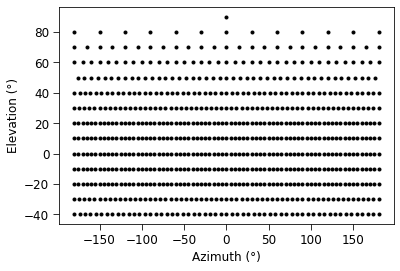

In [9]:
hrtf_locs, hrtf_firs, hrtf_sr = simulator.load_kemar_hrtfs(npz_filename='kemar_hrtfs/hrtfs.npz')

IDX_nonzero_azim = hrtf_locs[:, 1] != 0
opposite_hrtf_locs = hrtf_locs[IDX_nonzero_azim, :]
opposite_hrtf_locs[:, 1] = -1 * opposite_hrtf_locs[:, 1] # Multiply azimuth by negative one
opposite_hrtf_firs = np.flip(hrtf_firs[IDX_nonzero_azim, :, :], axis=2) # Switch left/right channel
hrtf_locs = np.concatenate([opposite_hrtf_locs, hrtf_locs], axis=0)
hrtf_firs = np.concatenate([opposite_hrtf_firs, hrtf_firs], axis=0)
hrtf_locs.shape, hrtf_firs.shape

"""
Check kemar_hrtf locations (azimuths and elevations)
"""
fig, ax = plt.subplots()
x = hrtf_locs[:, 1]
y = hrtf_locs[:, 2]
ax.plot(x, y, 'k.')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Azimuth (°)',
    str_ylabel='Elevation (°)')
plt.show()


In [ ]:
"""
Run this cell to start the MATLAB engine for Python and import `simulator_matlab`
"""
import matlab.engine
import simulator_matlab
importlib.reload(simulator_matlab)

eng = matlab.engine.start_matlab();
if 'src/' not in eng.path():
    eng.addpath('src/');


In [ ]:
"""
Quit MATLAB engine
"""
eng.quit()


In [ ]:
"""
DEBUGGING: CLOSELY COMPARE MATLAB AND PYTHON SIMULATORS UNDER DIFFERENT CONDITIONS

NOTES:
- Resulting BRIRs are sometimes offset by one or two samples
    - May be due to an off-by-one indexing error when porting MATLAB to Python
    - May be due to numerical precision differences
"""
room_materials = [26]*6#[1, 1, 1, 1, 15, 16]
room_dim_xyz = [7, 8, 4]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = -49
src_azim = 145
src_elev = 20
src_dist = 3.4
buffer = 0.5

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
incorporate_lead_zeros = True
use_log_distance = True
hrtf_locs = None
hrtf_firs = None

importlib.reload(simulator)

np.random.seed(0)
brir_python = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    hrtf_locs=hrtf_locs,
    hrtf_firs=hrtf_firs,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    processes=8,
    strict=True,
    verbose=2)


In [ ]:
importlib.reload(simulator_matlab)

np.random.seed(0)
brir_matlab = simulator_matlab.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    eng=eng)


In [ ]:
fig, ax_arr = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)

offset_brir_python = brir_python[1:]
offset_brir_matlab = brir_matlab[:-1]

ax_arr[0].plot(offset_brir_python[:, 0], 'b')
ax_arr[0].plot(offset_brir_python[:, 1], 'r')
ax_arr[0].plot(offset_brir_matlab[:, 0], 'c', ls=':')
ax_arr[0].plot(offset_brir_matlab[:, 1], 'm', ls=':')
ax_arr[1].plot(offset_brir_python[:, 0] - offset_brir_matlab[:, 0], 'b')
ax_arr[1].plot(offset_brir_python[:, 1] - offset_brir_matlab[:, 1], 'r')

for ax in ax_arr:
    util_figures.format_axes(
        ax,
        xlimits=[0, 500],
#         ylimits=[-0.01, 0.01]
    )
plt.show()


In [35]:
fn_manifest_brir = "/om2/user/msaddler/spatial_audio_pipeline/assets/brir/v00/manifest_brir.pdpkl"
df_manifest_brir = pd.read_pickle(fn_manifest_brir)
df_manifest_brir


,buffer,c,dur,head_azim,head_pos_xyz,incorporate_lead_zeros,index_brir,index_room,room_dim_xyz,room_materials,sr,src_azim,src_dist,src_elev,use_highpass,use_hrtf_symmetry,use_jitter,use_log_distance
0,0,344.5,0.5,30.365654,"[7.531689501460805, 5.031981696045566, 1.82493...",True,0,0,"[15.570789053085491, 12.019450985893185, 5.020...","[4, 6, 6, 6, 2, 17]",44100,0,1.400000,-40,True,True,True,False
1,0,344.5,0.5,30.365654,"[7.531689501460805, 5.031981696045566, 1.82493...",True,1,0,"[15.570789053085491, 12.019450985893185, 5.020...","[4, 6, 6, 6, 2, 17]",44100,0,1.400000,-30,True,True,True,False
2,0,344.5,0.5,30.365654,"[7.531689501460805, 5.031981696045566, 1.82493...",True,2,0,"[15.570789053085491, 12.019450985893185, 5.020...","[4, 6, 6, 6, 2, 17]",44100,0,1.400000,-20,True,True,True,False
3,0,344.5,0.5,30.365654,"[7.531689501460805, 5.031981696045566, 1.82493...",True,3,0,"[15.570789053085491, 12.019450985893185, 5.020...","[4, 6, 6, 6, 2, 17]",44100,0,1.400000,-10,True,True,True,False
4,0,344.5,0.5,30.365654,"[7.531689501460805, 5.031981696045566, 1.82493...",True,4,0,"[15.570789053085491, 12.019450985893185, 5.020...","[4, 6, 6, 6, 2, 17]",44100,0,1.400000,0,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167995,0,344.5,0.5,11.864372,"[9.331782817477075, 13.912040758282085, 0.9388...",True,1579,1999,"[28.9566297597882, 23.456638318908702, 3.56956...","[3, 6, 11, 11, 4, 17]",44100,355,5.341209,20,True,True,True,False
3167996,0,344.5,0.5,11.864372,"[9.331782817477075, 13.912040758282085, 0.9388...",True,1580,1999,"[28.9566297597882, 23.456638318908702, 3.56956...","[3, 6, 11, 11, 4, 17]",44100,355,3.264043,30,True,True,True,False
3167997,0,344.5,0.5,11.864372,"[9.331782817477075, 13.912040758282085, 0.9388...",True,1581,1999,"[28.9566297597882, 23.456638318908702, 3.56956...","[3, 6, 11, 11, 4, 17]",44100,355,3.393274,40,True,True,True,False
3167998,0,344.5,0.5,11.864372,"[9.331782817477075, 13.912040758282085, 0.9388...",True,1582,1999,"[28.9566297597882, 23.456638318908702, 3.56956...","[3, 6, 11, 11, 4, 17]",44100,355,1.670076,50,True,True,True,False


In [22]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

for _ in range(100):
    np.random.seed(_)
    room_parameters = generate_brir_manifest.sample_room_parameters(
        verbose=False)
    head_parameters = generate_brir_manifest.sample_head_parameters(
        room_dim_xyz=room_parameters['room_dim_xyz'],
        verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_azim = 0
    head_pos_xyz = head_parameters['head_pos_xyz']
    buffer = 0
    for src_azim in range(0, 360, 15):
        for src_elev in range(-60, 61, 5):
            src_dist = generate_brir_manifest.distance_to_wall(
                room_dim_xyz,
                head_pos_xyz,
                head_azim,
                src_azim,
                src_elev)
            src_pos_xyz = np.array([
                src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
                src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
                src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
            ])
            assert simulator.is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer), "Invalid head position"
            if (np.sum(np.isclose(src_pos_xyz, 0)) == 1) or (np.sum(np.isclose(src_pos_xyz, room_dim_xyz)) == 1):
                pass
            else:
                print(src_azim, src_elev, room_dim_xyz, src_pos_xyz)


/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/generate_brir_manifest.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  ry = (room_dim_xyz[1] - head_pos_xyz[1]) / (np.sin(np.deg2rad(azim)) * np.cos(np.deg2rad(elev)))


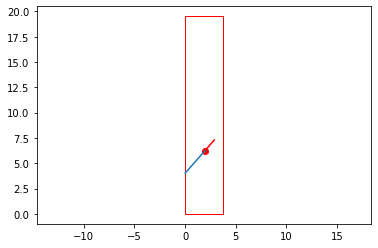

Checked src_azim: -180 = 180.0


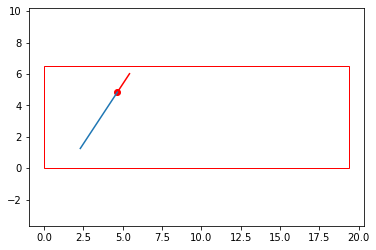

Checked src_azim: -180 = 180.0


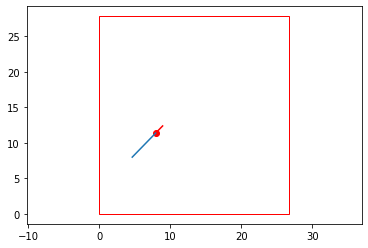

Checked src_azim: -180 = 180.0


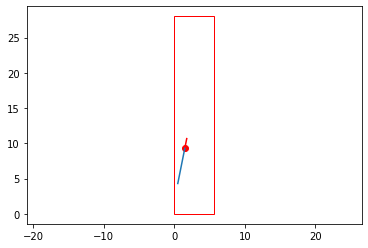

Checked src_azim: -180 = 179.99999914622634


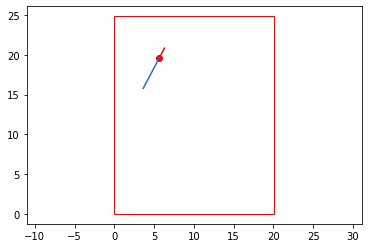

Checked src_azim: -180 = 179.99999914622634


In [23]:
import generate_brir_manifest
importlib.reload(generate_brir_manifest)

for _ in range(5):
    room_parameters = generate_brir_manifest.sample_room_parameters(verbose=False)
    head_parameters = generate_brir_manifest.sample_head_parameters(room_dim_xyz=room_parameters['room_dim_xyz'], verbose=False)
    room_dim_xyz = room_parameters['room_dim_xyz']
    head_azim = head_parameters['head_azim']
    head_pos_xyz = head_parameters['head_pos_xyz']
    
    fig, ax = plt.subplots()
    rect = matplotlib.patches.Rectangle((0, 0), room_dim_xyz[0], room_dim_xyz[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.plot(head_pos_xyz[0], head_pos_xyz[1], 'ro')
    src_azim = -180
    src_elev = 20
    src_dist = generate_brir_manifest.distance_to_wall(
        room_dim_xyz,
        head_pos_xyz,
        head_azim=head_azim,
        src_azim=src_azim,
        src_elev=src_elev)
    dhx = 1.4 * np.cos(np.deg2rad(head_azim))
    dhy = 1.4 * np.sin(np.deg2rad(head_azim))
    dx = src_dist * np.cos(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    dy = src_dist * np.sin(np.deg2rad(head_azim + src_azim)) * np.cos(np.deg2rad(src_elev))
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dhx], [head_pos_xyz[1], head_pos_xyz[1] + dhy], 'r-')
    ax.plot([head_pos_xyz[0], head_pos_xyz[0] + dx], [head_pos_xyz[1], head_pos_xyz[1] + dy])
    ax.set_aspect('equal', 'datalim')
    plt.show()
    
    vector1 = np.array([dx, dy])
    vector2 = np.array([dhx, dhy])
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.rad2deg(np.arccos(dot_product))
    print(f'Checked src_azim: {src_azim} = {angle}')
